Données provenant de [https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2019/](https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2019/)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates
import numpy as np
import json
import geopandas as gpd
plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2

In [2]:
# enable completion
%config Completer.use_jedi = False

In [3]:
def getInputs(annee, communes):
    if annee == '2019':
        sep = ';'
        dep = communes[0][:2]
    else:
        sep = ','
        dep = communes[0][:2] + '0'
        communes = [int(c[2:]) for c in communes]
        
    carac = pd.read_csv(f'input/{annee}/caracteristiques-{annee}.csv', sep=sep, dtype={'dep':str})
    lieu = pd.read_csv(f'input/{annee}/lieux-{annee}.csv', sep=sep)
    vehic = pd.read_csv(f'input/{annee}/vehicules-{annee}.csv', sep=sep)
    usager = pd.read_csv(f'input/{annee}/usagers-{annee}.csv', sep=sep)

    # combinaison de carac et lieu
    df_comb = pd.merge(carac, lieu, on='Num_Acc')
    mask = np.logical_and( df_comb['com'].isin(communes), df_comb.dep == dep )
    df_sel = df_comb[mask]

    if df_sel.lat.dtype == 'O':
        # conversion de latitude et longitude en float
        lat = df_sel['lat'].str.slice_replace(start=2, stop=3, repl='.').astype(float)
        long = df_sel['long'].str.slice_replace(start=1, stop=2, repl='.').astype(float)
    else:
        lat = df_sel.lat / 100000
        long = df_sel.long / 100000
    df_sel = df_sel.drop(columns=['lat', 'long'])
    df_sel['lat'] = lat
    df_sel['long'] = long
    
    # retirer NaN et 0
    df_sel = df_sel[np.logical_not( np.isnan(df_sel.long) )]
    df_sel = df_sel[ df_sel.long != 0. ]

    # restriction de vehic et usager pour les communes choisies
    acc_sel = df_sel.Num_Acc.to_numpy() # liste des accidents sélectionnés
    vehic_sel = vehic[vehic.Num_Acc.isin(acc_sel)]
    usager_sel = usager[usager.Num_Acc.isin(acc_sel)] 
    
    return df_sel, vehic_sel, usager_sel

In [18]:
def drawMap(df_list, vehic_list, usager_list, annee, frontiere, route, vehic_type=None, usager_type=None):  
    ax = frontiere.plot(color='white', edgecolor='black', linewidth=3)
    
    for i, df in enumerate(df_list):
        if vehic_type is not None:
            # accidents pour type de vehicules donné
            acc_vehic = vehic_list[i][vehic_list[i].catv==vehic_type].Num_Acc.to_numpy()
            df_new = df[df.Num_Acc.isin(acc_vehic)]
            gdf = gpd.GeoDataFrame(df_new, geometry=gpd.points_from_xy(df_new.long, df_new.lat))
            gdf.plot(ax=ax, label=annee[i], alpha=0.7, markersize=100, color='red')
        elif usager_type is not None:
            # accidents pour type d'usager donné
            mask_usa = usager_list[i].catu==usager_type
            mask_loc = np.logical_or( usager_list[i].locp == 3, usager_list[i].locp == 4 )
            acc_usa_pp = usager_list[i][np.logical_and(mask_usa, mask_loc)].Num_Acc.to_numpy()
            acc_usa_npp = usager_list[i][np.logical_and(mask_usa, np.logical_not(mask_loc))].Num_Acc.to_numpy()
            df_pp = df[df.Num_Acc.isin(acc_usa_pp)]
            df_npp = df[df.Num_Acc.isin(acc_usa_npp)]
            gdf_pp = gpd.GeoDataFrame(df_pp, geometry=gpd.points_from_xy(df_pp.long, df_pp.lat))            
            gdf_npp = gpd.GeoDataFrame(df_npp,
                                       geometry=gpd.points_from_xy(df_npp.long, df_npp.lat))            
            gdf_pp.plot(ax=ax, label='Sur passage piéton - {}'.format(annee[i]),
                        alpha=1, markersize=100, color='red')
            gdf_npp.plot(ax=ax, label='Hors passage piéton - {}'.format(annee[i]),
                         alpha=1, markersize=100, color='orange')
        else:
            gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.long, df.lat))
            gdf.plot(ax=ax, label=annee[i], alpha=0.7, markersize=100, color='red')
        
    route[route.fclass == 'primary'].plot(ax=ax, linewidth=3, color='grey')
    route[route.fclass == 'motorway'].plot(ax=ax, linewidth=3, color='grey')
    route[route.fclass == 'secondary'].plot(ax=ax, linewidth=2, color='grey')
    route[route.fclass == 'residential'].plot(ax=ax, linewidth=1, color='grey')
    route[route.fclass == 'unclassified'].plot(ax=ax, linewidth=1, color='grey')
    
    ax.legend()

In [5]:
com = gpd.read_file('input/communes-20210101-shp/communes-20210101.shp') #limites des communes
route = gpd.read_file('input/auvergne-latest-free.shp/gis_osm_roads_free_1.shp') # routes en auvergne

In [6]:
#communes = ['63113',  '63014', '63124', '63141', '63075', '63070',
#            '63254', '63193', '63284', '63019', '63164', '63063',
#            '63042', '63308', '63272', '63307', '63032',
#            '63042', '63099', '63263', '63345']

communes = ['63113', '63075']

# get municipality boundaries
metro = com[com.insee.isin(communes)]

# get roads
route_clipped = gpd.clip(route, metro)

In [7]:
annee = ['2019']
#annee = ['2019', '2018', '2017', '2016', '2015']

df_list = []
vehic_list = []
usager_list = []

for an in annee:
    df_sel, vehic_sel, usager_sel = getInputs(an, communes)
    df_list.append(df_sel)
    vehic_list.append(vehic_sel)
    usager_list.append(usager_sel)

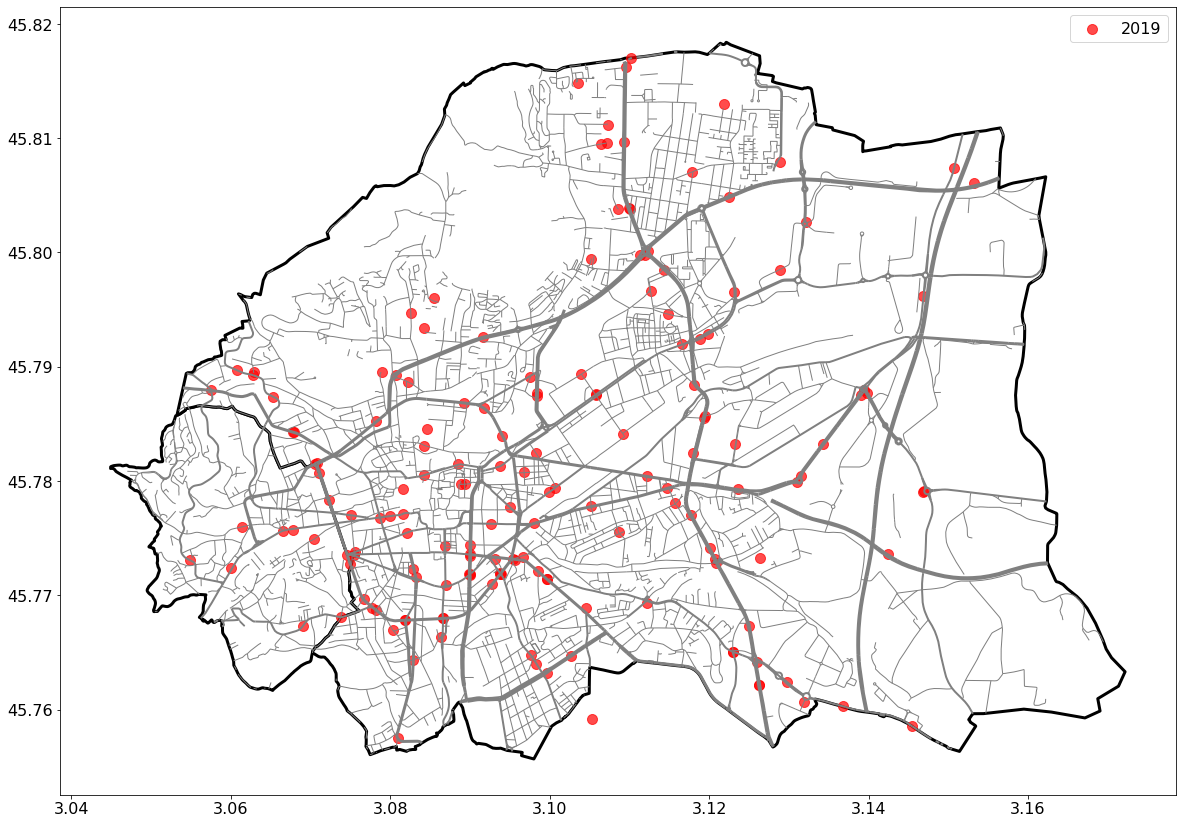

In [8]:
drawMap(df_list, vehic_list, usager_list, annee, metro, route_clipped)

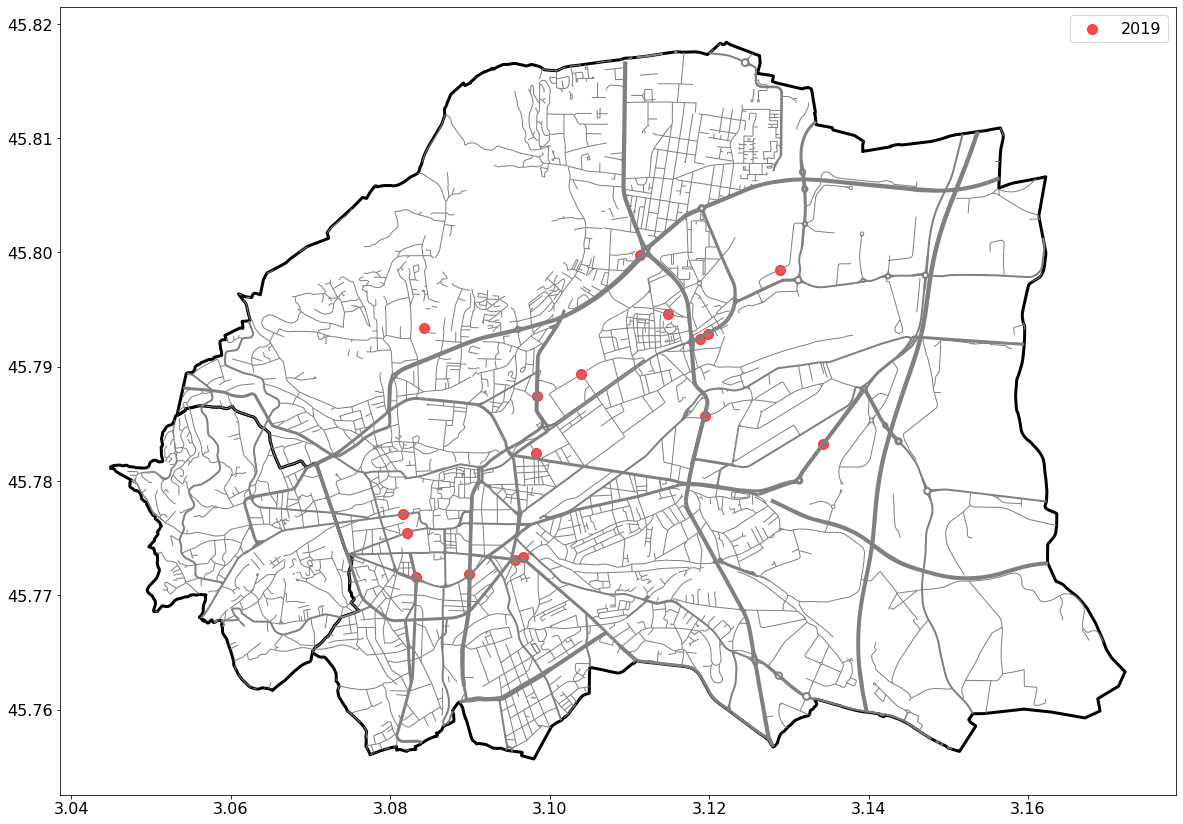

In [9]:
drawMap(df_list, vehic_list, usager_list, annee, metro, route_clipped, vehic_type=1)

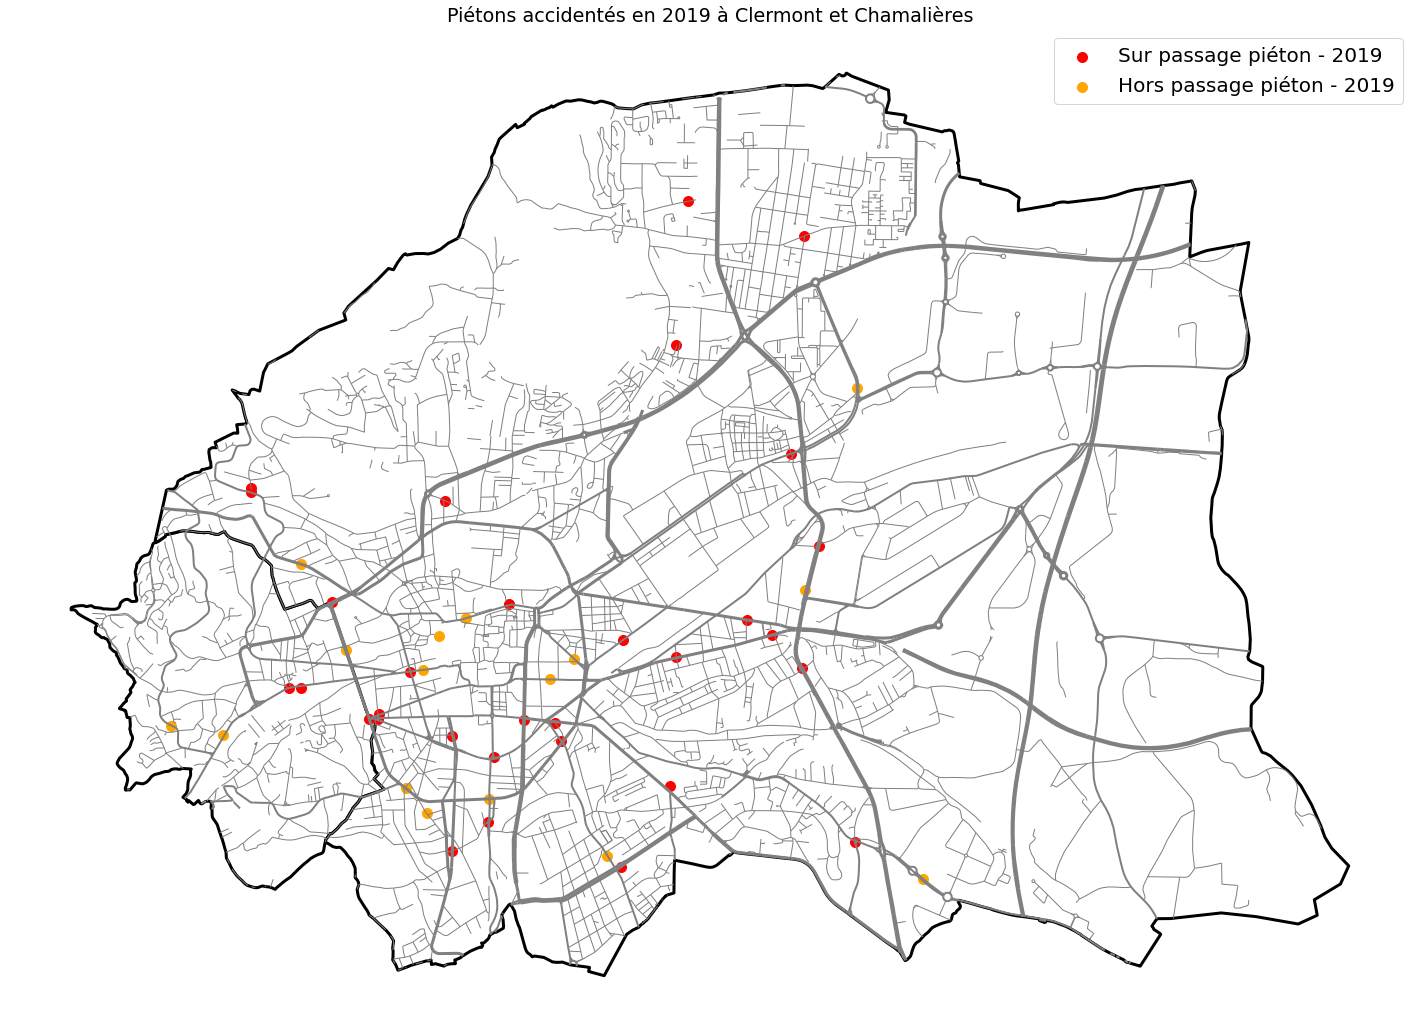

In [19]:
drawMap(df_list, vehic_list, usager_list, annee, metro, route_clipped, usager_type=3)
plt.title('Piétons accidentés en 2019 à Clermont et Chamalières')
plt.axis('off')
plt.tight_layout()
plt.savefig('pietons.jpg')

In [91]:
vehic_list[0][vehic_list[0].obsm==1]

,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc
177,201900000106,138 306 340,A01,1,7,0,1,1,15,1,NaN
1598,201900000962,138 304 788,A01,2,7,0,1,1,1,1,NaN
7254,201900004202,138 298 624,A01,1,30,0,1,8,13,1,NaN
8241,201900004781,138 297 468,A01,1,7,0,1,2,1,1,NaN
9576,201900005593,138 296 018,A01,2,7,0,1,1,1,1,NaN
9707,201900005669,138 295 869,A01,1,7,0,1,3,1,1,NaN
13009,201900007618,138 292 195,A01,2,7,0,1,1,1,1,NaN
13010,201900007619,138 292 194,A01,3,30,0,1,7,1,1,NaN
14966,201900008797,138 290 055,A01,1,10,0,1,1,1,1,NaN
18982,201900011156,138 285 777,A01,1,37,0,1,2,1,1,1.0


In [100]:
vehic_list[0][vehic_list[0].obsm==1].catv.value_counts()

7     38
10     3
30     2
37     2
14     1
40     1
Name: catv, dtype: int64

In [102]:
vehic_list[0][vehic_list[0].catv==1].obsm.value_counts()

2    16
0     2
Name: obsm, dtype: int64

In [103]:
vehic_list[0][vehic_list[0].catv==1].obs.value_counts()

0    17
8     1
Name: obs, dtype: int64

In [95]:
usager_pieton = usager_list[0][usager_list[0].catu==3]

In [101]:
usager_pieton

,Num_Acc,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
221,201900000106,138 306 340,A01,10,3,4,2,1957,0,8,0,-1,3,3,1
2081,201900000962,138 304 788,A01,10,3,3,1,1982,0,0,-1,-1,3,3,2
9439,201900004202,138 298 624,A01,10,3,4,2,1985,5,8,0,-1,0,1,1
12622,201900005593,138 296 018,A01,10,3,4,2,1990,5,0,-1,-1,3,3,1
12809,201900005669,138 295 869,A01,10,3,4,2,1969,0,8,0,-1,3,3,1
17224,201900007618,138 292 195,A01,10,3,3,1,1995,5,0,-1,-1,2,3,1
17226,201900007619,138 292 194,A01,10,3,4,2,1954,9,0,-1,-1,3,3,1
19855,201900008797,138 290 055,A01,10,3,4,1,1986,0,8,0,-1,3,3,1
25194,201900011156,138 285 777,A01,10,3,4,2,2008,0,8,0,-1,1,3,1
29840,201900013192,138 281 927,A01,10,3,4,2,1985,0,8,0,-1,1,3,1


In [96]:
usager_pieton.grav.value_counts()

4    30
3    17
2     1
Name: grav, dtype: int64

In [97]:
usager_pieton.actp.value_counts()

3    39
9     3
5     3
B     2
1     1
Name: actp, dtype: int64

In [99]:
usager_pieton.locp.value_counts()

3    18
4    14
2     5
1     4
9     4
5     2
0     1
Name: locp, dtype: int64

In [5]:
df_sel, vehic_sel, usager_sel = getInputs('2019', ['94069'])

In [6]:
usager_pieton = usager_list[0][usager_list[0].catu==3]

NameError: name 'usager_list' is not defined

In [17]:
import osmnx as ox
place_name = "Clermont-Ferrand"
graph = ox.graph_from_place(place_name, network_type='bike')

/home/theo/anaconda3/envs/geo-env/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


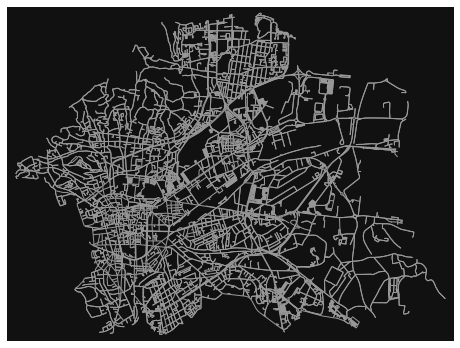

<AxesSubplot:>

<Figure size 1440x1440 with 0 Axes>

In [18]:
fig, ax = ox.plot_graph(graph, node_size=0)
gdf = gpd.GeoDataFrame(df_list[0], geometry=gpd.points_from_xy(df_list[0].long, df_list[0].lat))
gdf.plot(ax=ax, label='2019', alpha=0.7)

In [19]:
city = ox.geocode_to_gdf(place_name)

/home/theo/anaconda3/envs/geo-env/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
geo = ox.geometries_from_place(place_name, tags={'highway':True})

/home/theo/anaconda3/envs/geo-env/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


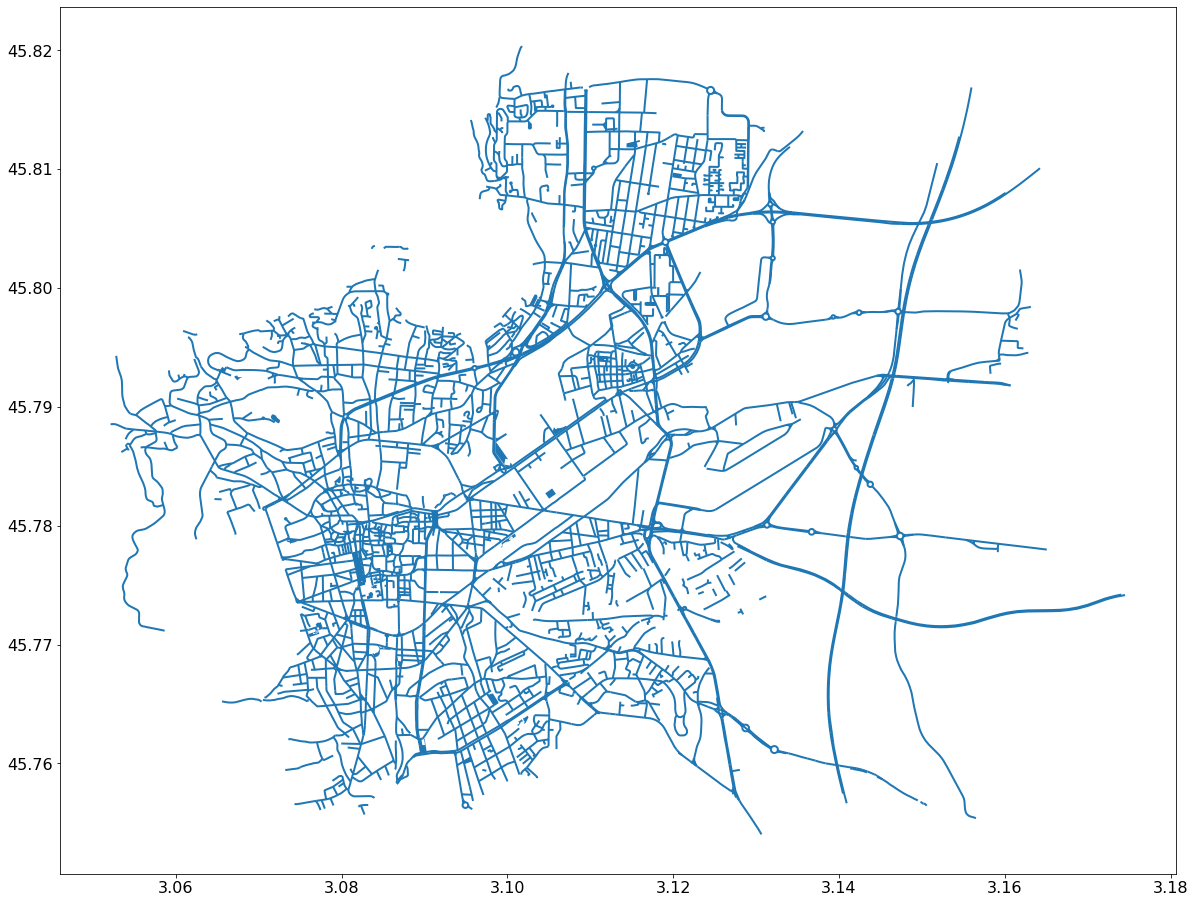

In [46]:
mask = geo.highway.isin(['pedestrian', 'primary', 'primary_link', 'secondary', 'secondary_link',
                         'tertiary', 'tertiary_link', 'residential', 'motorway'])
ax = geo[mask].plot()
#gdf = gpd.GeoDataFrame(df_list[0], geometry=gpd.points_from_xy(df_list[0].long, df_list[0].lat))
#gdf.plot(ax=ax, label='2019', alpha=0.7)

In [27]:
np.unique(geo.highway)

/home/theo/anaconda3/envs/geo-env/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['bus_stop', 'construction', 'corridor', 'crossing',
       'crossing;bus_stop', 'cycleway', 'elevator',
       'emergency_access_point', 'footway', 'give_way', 'living_street',
       'milestone', 'mini_roundabout', 'motorway', 'motorway_junction',
       'motorway_link', 'path', 'pedestrian', 'platform', 'primary',
       'primary_link', 'proposed', 'residential', 'rest_area', 'road',
       'secondary', 'secondary_link', 'service', 'speed_camera', 'steps',
       'stop', 'street_lamp', 'tertiary', 'tertiary_link', 'track',
       'traffic_signals', 'trunk', 'trunk_link', 'turning_circle',
       'turning_loop', 'unclassified'], dtype=object)